# BPHC Final Model Script: Random Forest and XG Boost Ensemble Method
### MIT Analytics Lab: Evan Hoch, Jacob Lebovitz, Jeremie Tarato, Jiao Zhao

Import necessart packages for modeling, plotting, and error metrics

In [85]:
# Dataframe
import pandas as pd 
import numpy as np 

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling Random Forest and sklearn packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Import XGBoost regressor
from xgboost import XGBRegressor

# If you get an error like "module [X] not defined" make sure you have installed that package in your current environment
# pip install [X] in your terminal usually fixes this error


Read in CSV, feature engineering, drop correlated columns

In [86]:
# Import CSV. If it fails, make sure the CSV is in the same path as the current directory
csv_file_name = 'BPHC Census Data 20251113.csv'
data = pd.read_csv(csv_file_name)

Data Cleaning Process: replace 0 and spikes with averaged values

In [87]:
def clean_with_neighbor_mean(
    df,
    features,
    diff_threshold=100,
    neighbor_window=2,   # number of neighbors on each side to use in the mean
    date_col="Date",
    inplace=False
):
    """

    A cell df.iloc[i, feature] is considered an outlier if:
      1) abs(value - previous) > diff_threshold
      2) abs(value - next) > diff_threshold
      3) abs(previous - next) <= diff_threshold  (neighbors agree with each other)

    When an outlier is found, its value is replaced by the mean of the
    neighbor_window nearest valid values before and after that index
    (2 before and 2 after by default).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe, assumed sorted by date and with a stable index.
    features : list of str
        Column names to clean.
    diff_threshold : float
        Threshold for detecting jumps between neighbors.
    neighbor_window : int
        How many neighbors on each side to average over.
    date_col : str
        Name of the date column, used only for interpretation and optional checks.
    inplace : bool
        If True, modify df in place. If False, work on a copy.

    Returns
    -------
    cleaned_df : pd.DataFrame
        Dataframe after cleaning.
    changes_log : pd.DataFrame
        Log of all changes with columns:
        ['index', 'feature', 'old_value', 'new_value']
    """
    if not inplace:
        df = df.copy()

    n_rows = len(df)
    changes = []
    
    # Step 0: Replace zeros in selected features using neighbor means BEFORE spike cleaning
    for feature in features:
        zero_idx = df.index[df[feature] == 0].tolist()

        for idx in zero_idx:
            pos = df.index.get_loc(idx)

            neighbor_vals = []
            for k in range(1, neighbor_window + 1):

                # before
                if pos - k >= 0:
                    v_before = df.iloc[pos - k][feature]
                    if not pd.isna(v_before) and v_before != 0:
                        neighbor_vals.append(v_before)

                # after
                if pos + k < n_rows:
                    v_after = df.iloc[pos + k][feature]
                    if not pd.isna(v_after) and v_after != 0:
                        neighbor_vals.append(v_after)

            if len(neighbor_vals) == 0:
                continue

            new_val = float(np.round(np.mean(neighbor_vals), 0))

            
            changes.append({
                "index": idx,
                "feature": feature,
                "old_value": 0,
                "new_value": new_val
            })

            
            df.at[idx, feature] = new_val



    # Optional safety check, does not modify anything
    if date_col in df.columns and not df[date_col].is_monotonic_increasing:
        print(f"Warning: {date_col} is not strictly sorted. Make sure df is ordered by date before calling this function.")

    for feature in features:
        if feature not in df.columns:
            print(f"Feature '{feature}' not found in dataframe. Skipping.")
            continue

        series = df[feature]

        # Work with positional indices but keep track of original index labels
        for pos in range(1, n_rows - 1):
            current_val = series.iloc[pos]
            prev_val = series.iloc[pos - 1]
            next_val = series.iloc[pos + 1]

            # Skip if any of the three core values are missing
            if pd.isna(current_val) or pd.isna(prev_val) or pd.isna(next_val):
                continue

            # Check if the middle value looks like an isolated spike
            big_jump_prev = abs(current_val - prev_val) > diff_threshold
            big_jump_next = abs(current_val - next_val) > diff_threshold

            if not (big_jump_prev and big_jump_next):
                continue

            # Collect neighbor values around this position
            neighbor_vals = []
            for k in range(1, neighbor_window + 1):
                # before
                if pos - k >= 0:
                    val_before = series.iloc[pos - k]
                    if not pd.isna(val_before):
                        neighbor_vals.append(val_before)
                # after
                if pos + k < n_rows:
                    val_after = series.iloc[pos + k]
                    if not pd.isna(val_after):
                        neighbor_vals.append(val_after)

            if len(neighbor_vals) == 0:
                # nothing to average, skip
                continue

            new_val = float(np.round(np.mean(neighbor_vals), 0))

            # Only log and write if there is an actual change
            if new_val != current_val:
                idx_label = df.index[pos]
                changes.append(
                    {
                        "index": idx_label,
                        "feature": feature,
                        "old_value": current_val,
                        "new_value": new_val,
                    }
                )
                df.at[idx_label, feature] = new_val


    changes_log = pd.DataFrame(changes, columns=["index", "feature", "old_value", "new_value"])
    return df, changes_log


In [88]:
# Normalize the data features so they all have a mean of 0 and SD of 1
# No need to normalize the target variable columns or Date/month/week
def normalize_df(df, exclude = ["Census_Both", "Census_Men", "Census_Women", "TotalCapacityOtherShelters", "CensusLTS", "Date", "Month", "Week"]):
    data.drop("Date", axis=1)
    df_normalized = df.copy()
    cols = [c for c in df if c not in exclude]
    means = df[cols].mean()
    stds = df[cols].std()
    
    df_normalized[cols] = (df[cols] - means) / stds
    
    return df_normalized

df_clean = clean_with_neighbor_mean(data, ["Census_Men", "Census_Women", "Census_Both"])[0]
df_normalized = normalize_df(df_clean)

In [89]:
# Create sin and cos columns for dates to capture seasonality
def transform_dates_in_sin(df):
    df = df.copy()  # avoid modifying original DataFrame

    month_number = df["Month"].dt.month
    w = df["Date"].dt.weekday + 1

    # compute all new columns first
    month_sin = np.sin(2 * np.pi * month_number / 12).round(2)
    month_cos = np.cos(2 * np.pi * month_number / 12).round(2)
    dow_sin = np.sin(2 * np.pi * w / 7).round(2)
    dow_cos = np.cos(2 * np.pi * w / 7).round(2)

    # combine everything at once
    df = pd.concat(
        [df.drop(columns=["Month"]),
         pd.DataFrame({
             "Month_sin": month_sin,
             "Month_cos": month_cos,
             "dow_sin": dow_sin,
             "dow_cos": dow_cos
         }, index=df.index)],
        axis=1
    )

    return df


In [90]:
# Drop columns function
def dropping_features(df, features): 
    for feature in features: 
        df = df.drop(feature, axis =1)
    return df

# Drop capacity and census_both columns
data_normalize = dropping_features(df_normalized, ["TotalCapacity_Men", "TotalCapacity_Women", "Census_Both", "TotalCapacity_Both"])


In [91]:
# Drop columns with a high covariance (keep 1, drop other)

def drop_high_covariance_features(df, threshold=0.8, target="Census_Men"):
    data = df.copy()

    # Save date column separately
    date_series = pd.to_datetime(data["Date"])
    df = data.drop(columns="Date", axis=1)

    # Separate features and target
    features = [c for c in df.columns if c != target]

    # Compute correlations
    corr = df[features].corr()
    target_corr = df[features].corrwith(df[target])

    to_drop = set()
    counter = 0

    # Iterate over feature pairs
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            a = features[i]
            b = features[j]

            # Skip if already dropped
            if a in to_drop or b in to_drop:
                continue

            # Check correlation between features (must be scalar)
            corr_val = abs((corr.loc[a, b]))

            if corr_val > threshold:
                # Compare absolute correlation with target
                corr_a = abs((target_corr.get(a, 0.0)))
                corr_b = abs((target_corr.get(b, 0.0)))

                if corr_a >= corr_b:
                    to_drop.add(b)
                else:
                    to_drop.add(a)
                counter += 1

    print(f"Dropping {len(to_drop)} features due to high covariance: {to_drop}")

    # Drop and restore date column
    df_no_covariance = df.drop(columns=list(to_drop), errors="ignore")
    df_no_covariance.insert(0, "Date", date_series)

    return df_no_covariance

    


In [92]:
def train_full_predict_future_tuned(clean_df, target_col="Census_Men", days_ahead=14):
    df = clean_df.copy().sort_values("Date").reset_index(drop=True)
    df[f"{target_col}_future"] = df[target_col].shift(-days_ahead)
    
    train_df = df.dropna(subset=[f"{target_col}_future"]).reset_index(drop=True)
    X = train_df.drop(columns=["Date", f"{target_col}_future"])
    y = train_df[f"{target_col}_future"]

    X = X.select_dtypes(include=[np.number])

    
    #imputer = SimpleImputer(strategy="mean")
    #X_imputed = imputer.fit_transform(X)
    
    #### XGB with GridSearchCV ####
    xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)
    param_grid = {
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 5, 7]
    }
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    best_xgb = grid_search.best_estimator_
    
    #### RF with RandomizedSearchCV ####
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_dist = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_leaf': [5, 10]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    rs = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=tscv, scoring='neg_mean_squared_error',
                            random_state=42, n_jobs=-1, verbose=1)
    rs.fit(X, y)
    best_rf = rs.best_estimator_
    
    #### Predict future ####
    X_future = df.drop(columns=["Date", f"{target_col}_future"]).iloc[-days_ahead:]
    X_future_numeric = X_future.select_dtypes(include=[np.number])
    #X_future_imputed = imputer.transform(X_future_numeric)
    
    y_pred_xgb = best_xgb.predict(X_future_numeric)
    y_pred_rf = best_rf.predict(X_future_numeric)
    
    y_pred = 0.35*y_pred_xgb + 0.65*y_pred_rf
    last_dates = pd.to_datetime(df["Date"].iloc[-days_ahead:]) + pd.to_timedelta(days_ahead, unit="D")
    
    predictions_df = pd.DataFrame({"Date": last_dates, "Predicted": np.round(y_pred,0)}).reset_index(drop=True)
    return predictions_df

In [ ]:
# def train_full_predict_future_tuned2(clean_df, target_col="Census_Men", days_ahead=14):
#     df = clean_df.copy().sort_values("Date").reset_index(drop=True)
#     df[f"{target_col}_future"] = df[target_col].shift(-days_ahead)
    
#     train_df = df.dropna(subset=[f"{target_col}_future"]).reset_index(drop=True)
#     X = train_df.drop(columns=["Date", f"{target_col}_future"])
#     y = train_df[f"{target_col}_future"]

#     X = X.select_dtypes(include=[np.number])
    
#     # XGBoost + GridSearchCV
#     xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)
#     param_grid = {
#         "n_estimators": [100, 200, 500],
#         "max_depth": [3, 5, 7]
#     }
#     grid_search = GridSearchCV(
#         xgb,
#         param_grid,
#         cv=5,
#         scoring="neg_mean_squared_error",
#         n_jobs=-1,
#         verbose=1
#     )
#     grid_search.fit(X, y)
#     best_xgb = grid_search.best_estimator_
#     best_xgb_params = grid_search.best_params_
    
#     # Random Forest + RandomizedSearchCV
#     rf = RandomForestRegressor(random_state=42, n_jobs=-1)
#     param_dist = {
#         "n_estimators": [100, 200],
#         "max_depth": [5, 10, None],
#         "min_samples_leaf": [5, 10]
#     }
#     tscv = TimeSeriesSplit(n_splits=5)

#     rs = RandomizedSearchCV(
#         rf,
#         param_dist,
#         n_iter=20,
#         cv=tscv,
#         scoring="neg_mean_squared_error",
#         random_state=42,
#         n_jobs=-1,
#         verbose=1
#     )
#     rs.fit(X, y)
#     best_rf = rs.best_estimator_
#     best_rf_params = rs.best_params_
    
#     # Future prediction
#     X_future = df.drop(columns=["Date", f"{target_col}_future"]).iloc[-days_ahead:]
#     X_future_numeric = X_future.select_dtypes(include=[np.number])
    
#     y_pred_xgb = best_xgb.predict(X_future_numeric)
#     y_pred_rf = best_rf.predict(X_future_numeric)

#     # Final ensemble
#     y_pred = 0.35 * y_pred_xgb + 0.65 * y_pred_rf
    
#     last_dates = pd.to_datetime(df["Date"].iloc[-days_ahead:]) + pd.to_timedelta(days_ahead, unit="D")
#     predictions_df = pd.DataFrame({
#         "Date": last_dates,
#         "Predicted": np.round(y_pred, 0)
#     }).reset_index(drop=True)

#     # Return predictions + best parameters
#     results = {
#         "predictions": predictions_df,
#         "best_xgb_params": best_xgb_params,
#         "best_rf_params": best_rf_params,
#         "best_xgb_model": best_xgb,
#         "best_rf_model": best_rf,
#     }
#     return results


# def main2(df, target_col="Census_Men", day_ahead=14, covariance_threshhold=0.8, exclude_from_normalization = ["Census_Both", "Census_Men", "Census_Women", "TotalCapacityOtherShelters", "CensusLTS", "Date", "Month", "Week"]): 
#     df["Date"] = pd.to_datetime(df["Date"])
#     df["Month"] = pd.to_datetime(df["Month"])

#     features_to_clean = [
#     "Census_Men",
#     "Census_Women",
#     "Census_Both",
#     "TotalCapacityOtherShelters",
#     ]
    
#     data_clean, log_changes = clean_with_neighbor_mean(
#         df,
#         features=features_to_clean,
#         diff_threshold=100,
#         neighbor_window=2,
#         date_col="Date",
#         inplace=False
#     )


#     df_normalize = normalize_df(data_clean, exclude_from_normalization)
#     data_normalize_sin = transform_dates_in_sin(df_normalize)
#     features = ["TotalCapacity_Men", "TotalCapacity_Women", "Census_Both", "TotalCapacity_Both"]
#     df_dropped = dropping_features(data_normalize_sin, features)
#     df_dropped = df_dropped.drop(columns = "Week")

#     df_no_cov = drop_high_covariance_features(df_dropped, threshold=covariance_threshhold)
#     predictions = train_full_predict_future_tuned2(df_no_cov, target_col=target_col, days_ahead=day_ahead)
#     return predictions

# # Add parameters and variables to allow for flexibility
# exclude_from_norm = ["Census_Both", "Census_Men", "Census_Women", "TotalCapacityOtherShelters", "CensusLTS", "Date", "Month", "Week"]

# predictions = main2(df=data, target_col="Census_Men", day_ahead=14, covariance_threshhold=0.8, exclude_from_normalization=exclude_from_norm)
# predictions

Dropping 18 features due to high covariance: {'ZHVILowUS', 'ZHVILowBOS', 'ZHVIMidUS', 'ZORISingleUS', 'LTSSitesOpen', 'ZORIMultiUS', 'ZHVIHighUS', 'Call311_Other', 'ZORIMultiBOS', 'SFRForSaleBOS', 'TempMinF', 'ZHVIHighBOS', 'MedPriceAllBOS', 'ZORISingleBOS', 'HomesForSaleBOS', 'MedPriceSFRBOS', 'TempAvgF', 'CensusLTS'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'predictions':                         Date  Predicted
 0  2025-10-01 00:00:00+00:00      437.0
 1  2025-10-02 00:00:00+00:00      437.0
 2  2025-10-03 00:00:00+00:00      421.0
 3  2025-10-04 00:00:00+00:00      419.0
 4  2025-10-05 00:00:00+00:00      429.0
 5  2025-10-06 00:00:00+00:00      435.0
 6  2025-10-07 00:00:00+00:00      463.0
 7  2025-10-08 00:00:00+00:00      439.0
 8  2025-10-09 00:00:00+00:00      470.0
 9  2025-10-10 00:00:00+00:00      431.0
 10 2025-10-11 00:00:00+00:00      427.0
 11 2025-10-12 00:00:00+00:00      431.0
 12 2025-10-13 00:00:00+00:00      427.0
 13 2025-10-14 00:00:00+00:00      457.0,
 'best_xgb_params': {'max_depth': 3, 'n_estimators': 100},
 'best_rf_params': {'n_estimators': 100,
  'min_samples_leaf': 5,
  'max_depth': 5},
 'best_xgb_model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
       

## We have found the best hyperparameter for model 1

###  'best_xgb_params': {'max_depth': 3, 'n_estimators': 100},
###  'best_rf_params': {'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 5}

In [ ]:
def main(df, target_col="Census_Men", day_ahead=14, covariance_threshhold=0.8, exclude_from_normalization = ["Census_Both", "Census_Men", "Census_Women", "TotalCapacityOtherShelters", "CensusLTS", "Date", "Month", "Week"]): 
    df["Date"] = pd.to_datetime(df["Date"])
    df["Month"] = pd.to_datetime(df["Month"])

    features_to_clean = [
    "Census_Men",
    "Census_Women",
    "Census_Both",
    "TotalCapacityOtherShelters",
    ]
    
    data_clean, log_changes = clean_with_neighbor_mean(
        df,
        features=features_to_clean,
        diff_threshold=100,
        neighbor_window=2,
        date_col="Date",
        inplace=False
    )


    df_normalize = normalize_df(data_clean, exclude_from_normalization)
    data_normalize_sin = transform_dates_in_sin(df_normalize)
    features = ["TotalCapacity_Men", "TotalCapacity_Women", "Census_Both", "TotalCapacity_Both"]
    df_dropped = dropping_features(data_normalize_sin, features)
    df_dropped = df_dropped.drop(columns = "Week")

    df_no_cov = drop_high_covariance_features(df_dropped, threshold=covariance_threshhold)
    predictions = train_full_predict_future_tuned(df_no_cov, target_col=target_col, days_ahead=day_ahead)
    return predictions






In [95]:
# Add parameters and variables to allow for flexibility
exclude_from_norm = ["Census_Both", "Census_Men", "Census_Women", "TotalCapacityOtherShelters", "CensusLTS", "Date", "Month", "Week"]

# predictions = main(df=data, target_col="Census_Men", day_ahead=14, covariance_threshhold=0.8, exclude_from_normalization=exclude_from_norm)

In [96]:
# import numpy as np
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# def ar_trend_walkforward(
#     df,
#     target_col="Census_Men",
#     days_ahead=14,
#     lags=(15,16,22),
#     train_window=500,
#     test_size=15,
#     use_cleaning=True,
# ):
#     """
#     Univariate autoregressive model with trend features and walkforward evaluation.

#     Uses only past values of target_col and their differences to predict
#     target_col at t + days_ahead.

#     Features:
#       lag_k = y(t - k) for each k in lags
#       diff_1 = y(t) minus y(t - 1)
#       diff_7 = y(t) minus y(t - 7)

#     Walkforward scheme:
#       train on [start, start + train_window)
#       skip a gap of length days_ahead
#       test on [train_end + gap, train_end + gap + test_size)
#       then move start forward by test_size
#     """

#     # 1. optional spike cleaning on the target, to stay consistent with your pipeline
#     if use_cleaning:
#         df_clean, _ = clean_with_neighbor_mean(
#             df,
#             features=[target_col],
#             diff_threshold=100,
#             neighbor_window=2,
#             date_col="Date",
#             inplace=False,
#         )
#     else:
#         df_clean = df.copy()

#     work = df_clean.copy().sort_values("Date").reset_index(drop=True)
#     work["Date"] = pd.to_datetime(work["Date"])
#     y = work[target_col]

#     # 2. build future target
#     future_col = f"{target_col}_future"
#     work[future_col] = y.shift(-days_ahead)

#     # 3. lag features
#     for k in lags:
#         work[f"lag_{k}"] = y.shift(k)

#     # 4. simple trend features
#     work["diff_1"] = y - y.shift(1)
#     work["diff_7"] = y - y.shift(7)

#     # feature_cols = [f"lag_{k}" for k in lags] + ["diff_1", "diff_7"]
#     feature_cols = [f"lag_{k}" for k in lags]


#     # 5. remove rows without a valid future target or features
#     work = work.dropna(subset=[future_col] + feature_cols).reset_index(drop=True)

#     X = work[feature_cols].values
#     y_future = work[future_col].values
#     y_naive = work[target_col].values     # for baseline comparison
#     dates_all = work["Date"].dt.tz_localize(None).to_numpy() + np.timedelta64(days_ahead, "D")

#     n = len(work)
#     gap = days_ahead

#     if n < train_window + gap + test_size:
#         raise ValueError(f"Not enough data for train_window={train_window}, gap={gap}, test_size={test_size}; n={n}")

#     # 6. walkforward evaluation
#     all_y_true = []
#     all_y_pred = []
#     all_y_naive = []
#     all_dates = []

#     start = 0
#     while True:
#         train_end = start + train_window
#         test_start = train_end + gap
#         test_end = test_start + test_size

#         if test_end > n:
#             break

#         train_start = start
#         X_train = X[train_start:train_end]
#         y_train = y_future[train_start:train_end]


#         X_test = X[test_start:test_end]
#         y_test = y_future[test_start:test_end]
#         y_naive_test = y_naive[test_start:test_end]
#         dates_test = dates_all[test_start:test_end]

#         model = LinearRegression()
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)

#         all_y_true.append(y_test)
#         all_y_pred.append(y_pred)
#         all_y_naive.append(y_naive_test)
#         all_dates.append(dates_test)

#         start = start + test_size

#     all_y_true = np.concatenate(all_y_true)
#     all_y_pred = np.concatenate(all_y_pred)
#     all_y_naive = np.concatenate(all_y_naive)
#     all_dates = np.concatenate(all_dates)

#     rmse_model = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
#     rmse_naive = np.sqrt(mean_squared_error(all_y_true, all_y_naive))

#     predictions_df = pd.DataFrame(
#         {
#             "Date": all_dates,
#             "Actual": all_y_true,
#             "Naive": all_y_naive,
#             "AR_trend_pred": np.round(all_y_pred, 0),
#         }
#     ).sort_values("Date").reset_index(drop=True)

#     metrics = {
#         "rmse_model": rmse_model,
#         "rmse_naive": rmse_naive,
#         "feature_cols": feature_cols,
#     }

#     return predictions_df, metrics


In [97]:
# preds_ar, metrics_ar = ar_trend_walkforward(
#     df=data,
#     target_col="Census_Men",
#     days_ahead=14,
#     lags=(15, 16, 22),
#     train_window=500,
#     test_size=15,
# )

# print("RMSE naive:", round(metrics_ar["rmse_naive"], 2))
# print("RMSE AR trend:", round(metrics_ar["rmse_model"], 2))
# print("Features used:", metrics_ar["feature_cols"])
# preds_ar.head(20)


In [98]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

def ar_trend_walkforward(
    df,
    target_col="Census_Men",
    days_ahead=14,
    lags=(1, 7, 14),
    train_window=300,
    test_size=15,
    use_cleaning=True,
    alpha=None,   # None means OLS, >0 means Lasso
):
    """
    Univariate autoregressive model with trend features and walkforward evaluation.

    Uses only past values of target_col and their differences to predict
    target_col at t + days_ahead.

    Features:
      lag_k = y(t - k) for each k in lags
      diff_1 = y(t) minus y(t - 1)
      diff_7 = y(t) minus y(t - 7)

    Walkforward scheme:
      train on [start, start + train_window)
      skip a gap of length days_ahead
      test on [train_end + gap, train_end + gap + test_size)
      then move start forward by test_size
    """

    # 1. optional spike cleaning on the target
    if use_cleaning:
        df_clean, _ = clean_with_neighbor_mean(
            df,
            features=[target_col],
            diff_threshold=100,
            neighbor_window=2,
            date_col="Date",
            inplace=False,
        )
    else:
        df_clean = df.copy()

    work = df_clean.copy().sort_values("Date").reset_index(drop=True)
    work["Date"] = pd.to_datetime(work["Date"])
    y = work[target_col]

    # 2. future target
    future_col = f"{target_col}_future"
    work[future_col] = y.shift(-days_ahead)

    # 3. lag features
    for k in lags:
        work[f"lag_{k}"] = y.shift(k)

    # 4. trend features
    work["diff_1"] = y - y.shift(1)
    work["diff_7"] = y - y.shift(7)

    feature_cols = [f"lag_{k}" for k in lags] + ["diff_1", "diff_7"]

    # 5. drop rows with missing features or target
    work = work.dropna(subset=[future_col] + feature_cols).reset_index(drop=True)

    X = work[feature_cols].values
    y_future = work[future_col].values
    y_naive = work[target_col].values
    dates_all = work["Date"].dt.tz_localize(None).to_numpy() + np.timedelta64(days_ahead, "D")

    n = len(work)
    gap = days_ahead

    if n < train_window + gap + test_size:
        raise ValueError(f"Not enough data: n={n}, need >= {train_window + gap + test_size}")

    # 6. walkforward evaluation
    all_y_true = []
    all_y_pred = []
    all_y_naive = []
    all_dates = []

    start = 0
    while True:
        train_end = start + train_window
        test_start = train_end + gap
        test_end = test_start + test_size

        if test_end > n:
            break

        train_start = start
        X_train = X[train_start:train_end]
        y_train = y_future[train_start:train_end]

        X_test = X[test_start:test_end]
        y_test = y_future[test_start:test_end]
        y_naive_test = y_naive[test_start:test_end]
        dates_test = dates_all[test_start:test_end]

        # choose model type
        if alpha is None or alpha == 0:
            model = LinearRegression()
        else:
            model = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_y_true.append(y_test)
        all_y_pred.append(y_pred)
        all_y_naive.append(y_naive_test)
        all_dates.append(dates_test)

        start += test_size

    all_y_true = np.concatenate(all_y_true)
    all_y_pred = np.concatenate(all_y_pred)
    all_y_naive = np.concatenate(all_y_naive)
    all_dates = np.concatenate(all_dates)

    rmse_model = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
    rmse_naive = np.sqrt(mean_squared_error(all_y_true, all_y_naive))

    predictions_df = pd.DataFrame(
        {
            "Date": all_dates,
            "Actual": all_y_true,
            "Naive": all_y_naive,
            "AR_trend_pred": np.round(all_y_pred, 0),
        }
    ).sort_values("Date").reset_index(drop=True)

    metrics = {
        "rmse_model": rmse_model,
        "rmse_naive": rmse_naive,
        "feature_cols": feature_cols,
        "alpha": alpha,
        "lags": lags,
        "train_window": train_window,
        "test_size": test_size,
    }

    return predictions_df, metrics

preds, metrics = ar_trend_walkforward(
    df=data,
    target_col="Census_Men",
    days_ahead=14,
    lags=(1, 2, 7, 14),
    train_window=1000,
    test_size=15,
    use_cleaning=True,
    alpha=0.1,   # Lasso
)

print("RMSE naive:", round(metrics["rmse_naive"], 2))
print("RMSE AR trend:", round(metrics["rmse_model"], 2))
metrics


RMSE naive: 30.94
RMSE AR trend: 27.17


{'rmse_model': 27.17163204411391,
 'rmse_naive': 30.935043137829854,
 'feature_cols': ['lag_1', 'lag_2', 'lag_7', 'lag_14', 'diff_1', 'diff_7'],
 'alpha': 0.1,
 'lags': (1, 2, 7, 14),
 'train_window': 1000,
 'test_size': 15}

In [99]:
def tune_ar_trend_hyperparams(
    df,
    target_col="Census_Men",
    days_ahead=14,
    lag_grid=None,
    train_window_grid=None,
    alpha_grid=None,
    test_size=15,
    use_cleaning=True,
):
    """
    Simple grid search over lags, train_window, alpha using walkforward evaluation.
    Returns a list of all results sorted by model RMSE.
    """

    if lag_grid is None:
        lag_grid = [
            (1, 2, 3, 7, 14),
            (1, 7, 14, 21, 28),
            (1, 2, 3, 7, 10, 14, 18, 21),

        ]

    if train_window_grid is None:
        train_window_grid = [300, 500, 1000]

    if alpha_grid is None:
        alpha_grid = [0.0, 0.05, 0.1, 0.2]   # 0 means OLS

    results = []

    for lags in lag_grid:
        for train_window in train_window_grid:
            for alpha in alpha_grid:
                try:
                    _, metrics = ar_trend_walkforward(
                        df=df,
                        target_col=target_col,
                        days_ahead=days_ahead,
                        lags=lags,
                        train_window=train_window,
                        test_size=test_size,
                        use_cleaning=use_cleaning,
                        alpha=alpha if alpha > 0 else None,
                    )
                except ValueError as e:
                    # not enough data for that combination; skip
                    continue

                results.append(
                    {
                        "lags": lags,
                        "train_window": train_window,
                        "alpha": alpha,
                        "rmse_model": metrics["rmse_model"],
                        "rmse_naive": metrics["rmse_naive"],
                    }
                )

    # sort by model RMSE
    results_sorted = sorted(results, key=lambda r: r["rmse_model"])
    return results_sorted


In [100]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [ ]:
grid_results = tune_ar_trend_hyperparams(
    df=data,
    target_col="Census_Men",
    days_ahead=14,
    test_size=15,
    use_cleaning=True,
)

# show the five best combinations
for r in grid_results[:10]:
    print(
        f"lags={r['lags']}, train_window={r['train_window']}, alpha={r['alpha']}, "
        f"RMSE_model={r['rmse_model']:.2f}, RMSE_naive={r['rmse_naive']:.2f}"
    )


lags=(1, 2, 3, 7, 14), train_window=1000, alpha=0.0, RMSE_model=30.88, RMSE_naive=32.79
lags=(1, 2, 3, 7, 14), train_window=1000, alpha=0.05, RMSE_model=30.89, RMSE_naive=32.79
lags=(1, 2, 3, 7, 14), train_window=1000, alpha=0.1, RMSE_model=30.89, RMSE_naive=32.79
lags=(1, 2, 3, 7, 14), train_window=1000, alpha=0.2, RMSE_model=30.89, RMSE_naive=32.79
lags=(1, 2, 3, 7, 10, 14, 18, 21), train_window=1000, alpha=0.0, RMSE_model=30.92, RMSE_naive=32.69
lags=(1, 7, 14, 21, 28), train_window=1000, alpha=0.0, RMSE_model=30.96, RMSE_naive=32.74
lags=(1, 2, 3, 7, 10, 14, 18, 21), train_window=1000, alpha=0.05, RMSE_model=30.96, RMSE_naive=32.69
lags=(1, 2, 3, 7, 10, 14, 18, 21), train_window=1000, alpha=0.1, RMSE_model=30.96, RMSE_naive=32.69
lags=(1, 2, 3, 7, 10, 14, 18, 21), train_window=1000, alpha=0.2, RMSE_model=30.96, RMSE_naive=32.69
lags=(1, 2, 3, 7, 14), train_window=500, alpha=0.05, RMSE_model=31.00, RMSE_naive=32.89


In [102]:
best = grid_results[3]
preds_best, metrics_best = ar_trend_walkforward(
    df=data,
    target_col="Census_Men",
    days_ahead=14,
    lags=best["lags"],
    train_window=best["train_window"],
    test_size=15,
    use_cleaning=True,
    alpha=best["alpha"],
)

print(metrics_best)
preds_best


{'rmse_model': 26.887899363354926, 'rmse_naive': 30.708460134131176, 'feature_cols': ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_10', 'lag_14', 'lag_18', 'lag_21', 'diff_1', 'diff_7'], 'alpha': 0.1, 'lags': (1, 2, 3, 7, 10, 14, 18, 21), 'train_window': 1000, 'test_size': 15}


,Date,Actual,Naive,AR_trend_pred
0,2018-07-16,475.0,472,476.0
1,2018-07-17,513.0,443,479.0
2,2018-07-18,492.0,431,474.0
3,2018-07-19,455.0,474,460.0
4,2018-07-20,406.0,437,438.0
...,...,...,...,...
2620,2025-09-17,379.0,425,403.0
2621,2025-09-18,412.0,439,414.0
2622,2025-09-19,379.0,371,392.0
2623,2025-09-20,370.0,372,383.0


c for 66 percent within ±c: 23.0
c for 95 percent within ±c: 54.8


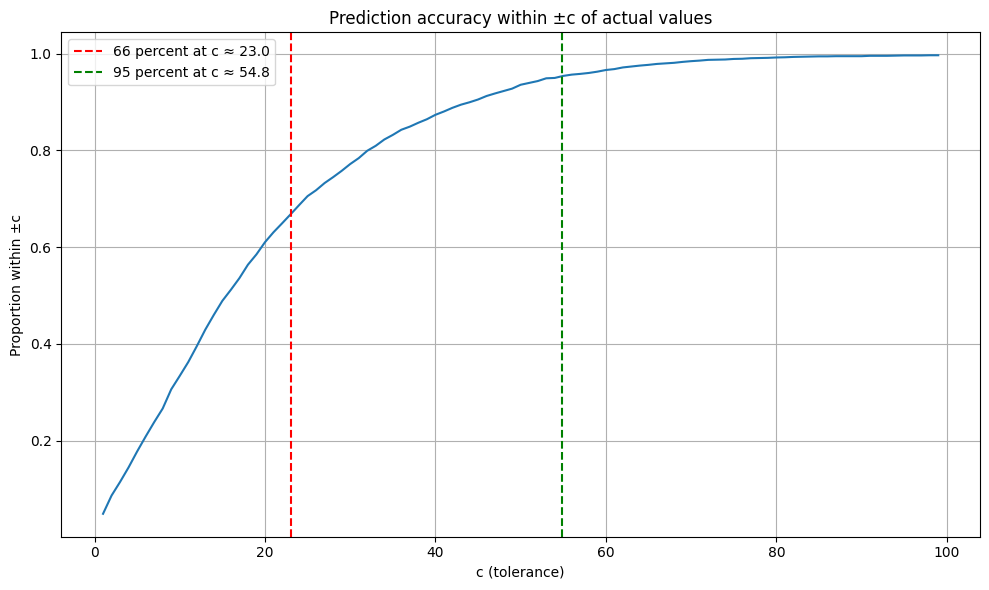

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

mens_predictions = preds_best.copy()

# Ensure numeric columns
mens_predictions["Actual"] = pd.to_numeric(mens_predictions["Actual"])
mens_predictions["AR_trend_pred"] = pd.to_numeric(mens_predictions["AR_trend_pred"])

# Absolute errors
abs_err = (mens_predictions["Actual"] - mens_predictions["AR_trend_pred"]).abs().values

# c such that about 66 percent and 95 percent of predictions are within ±c
c_66 = np.quantile(abs_err, 0.66)
c_95 = np.quantile(abs_err, 0.95)

print(f"c for 66 percent within ±c: {c_66:.1f}")
print(f"c for 95 percent within ±c: {c_95:.1f}")

# Proportion within ±c for a grid of c values, as you already had
c_values = range(1, 100)
proportions = []

for c in c_values:
    diff = abs_err
    within_c = (diff <= c).mean()
    proportions.append(within_c)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(c_values, proportions)
plt.xlabel("c (tolerance)")
plt.ylabel("Proportion within ±c")
plt.title("Prediction accuracy within ±c of actual values")
plt.grid(True)

# Show vertical lines for c_66 and c_95
plt.axvline(c_66, color="red", linestyle="--", label=f"66 percent at c ≈ {c_66:.1f}")
plt.axvline(c_95, color="green", linestyle="--", label=f"95 percent at c ≈ {c_95:.1f}")
plt.legend()
plt.tight_layout()
plt.show()


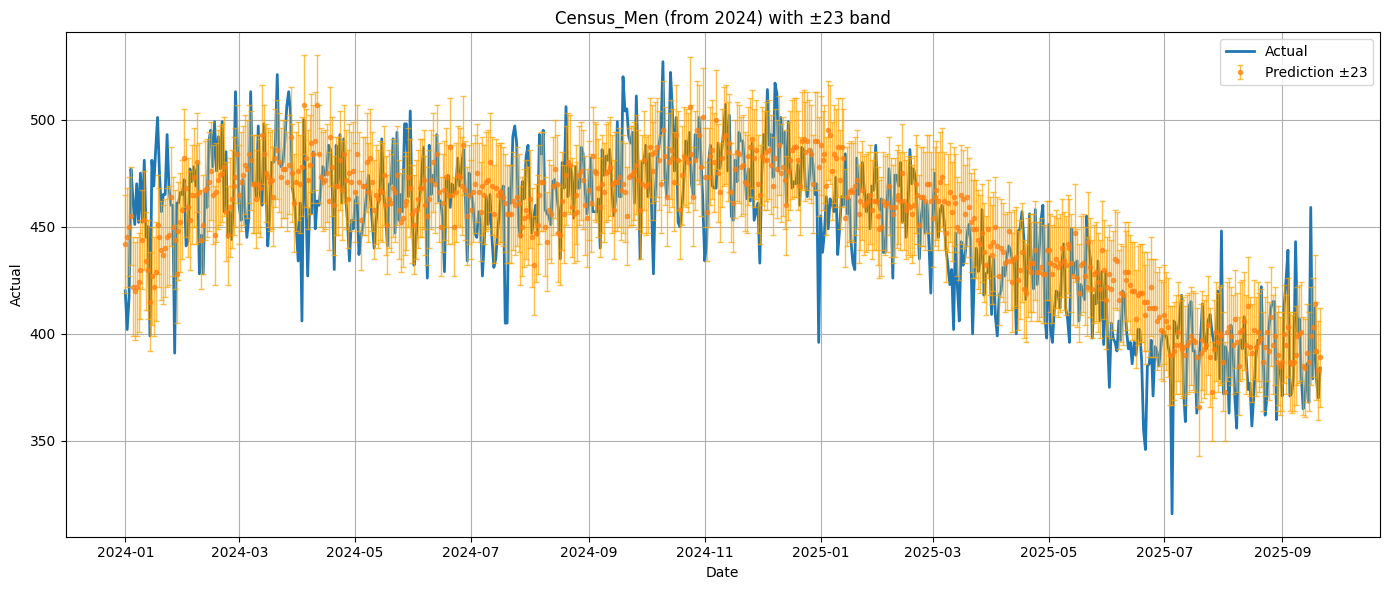

In [104]:
def plot_predictions_with_error_bars(
    df,
    date_col="Date",
    actual_col="Actual",
    pred_col="AR_trend_pred",
    band=30,          # half width of the error bar
    start_date=None,  # optional subset
    end_date=None,
    title="Actual vs predicted with error bars",
):
    """
    df must contain columns:
      date_col
      actual_col
      pred_col

    band is the plus or minus range for error bars around predictions.
    """

    plot_df = df.copy()
    plot_df[date_col] = pd.to_datetime(plot_df[date_col])

    # optional date filter
    if start_date is not None:
        plot_df = plot_df[plot_df[date_col] >= pd.to_datetime(start_date)]
    if end_date is not None:
        plot_df = plot_df[plot_df[date_col] <= pd.to_datetime(end_date)]

    plot_df = plot_df.sort_values(date_col)

    x = plot_df[date_col]
    y_actual = plot_df[actual_col]
    y_pred = plot_df[pred_col]

    plt.figure(figsize=(14, 6))

    # actual as line
    plt.plot(x, y_actual, label="Actual", linewidth=2)

    # predictions with error bars
    plt.errorbar(
        x,
        y_pred,
        yerr=band,
        fmt="o",
        markersize=3,
        ecolor="orange",
        elinewidth=1,
        capsize=2,
        alpha=0.7,
        label=f"Prediction ±{band}",
    )

    plt.xlabel("Date")
    plt.ylabel(actual_col)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

plot_predictions_with_error_bars(
    mens_predictions,
    band=23,
    start_date="2024-01-01",
    title="Census_Men (from 2024) with ±23 band",
)



/var/folders/jg/_l44w3vn7_7506fmgw59pc7h0000gn/T/ipykernel_64187/195937803.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(blocks))


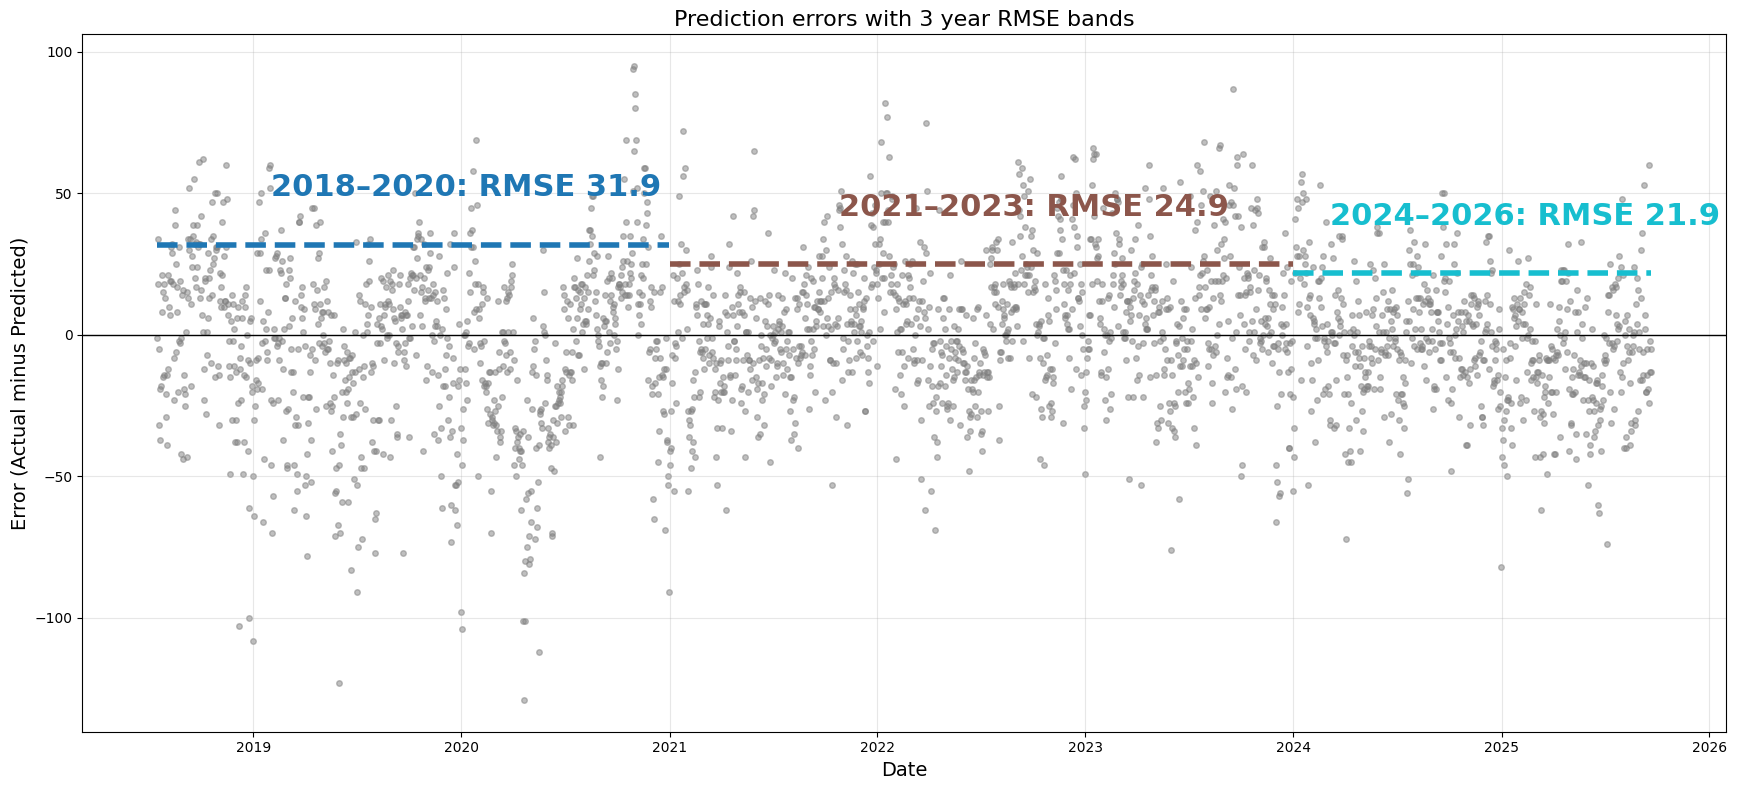

In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_all_errors_with_rmse_3yr(
    df,
    date_col="Date",
    actual_col="Actual",
    pred_col="AR_trend_pred",
    title="Prediction errors with 3 year RMSE bands"
):
    """
    Plot all daily errors in grey, and add thick RMSE lines
    computed over 3 year blocks (e.g., 2018 to 2020).
    """

    df_plot = df.copy()
    df_plot[date_col] = pd.to_datetime(df_plot[date_col])
    df_plot = df_plot.sort_values(date_col)

    # signed error
    df_plot["error"] = df_plot[actual_col] - df_plot[pred_col]
    df_plot["year"] = df_plot[date_col].dt.year

    years = sorted(df_plot["year"].unique())
    year_min = years[0]
    year_max = years[-1]

    # build 3 year bins
    blocks = []
    start = year_min
    while start <= year_max:
        end = start + 2  # 3 year span
        blocks.append((start, end))
        start = end + 1

    cmap = plt.cm.get_cmap("tab10", len(blocks))

    plt.figure(figsize=(18, 8))

    # all errors in grey
    plt.scatter(
        df_plot[date_col],
        df_plot["error"],
        s=16,
        color="grey",
        alpha=0.5,
        label="Daily errors"
    )

    # RMSE per 3 year block
    for i, (y_start, y_end) in enumerate(blocks):
        df_block = df_plot[(df_plot["year"] >= y_start) & (df_plot["year"] <= y_end)]
        if df_block.empty:
            continue

        rmse = np.sqrt(np.mean(df_block["error"]**2))
        color = cmap(i)

        # horizontal RMSE line spanning that 3 year block
        plt.hlines(
            rmse,
            df_block[date_col].min(),
            df_block[date_col].max(),
            colors=color,
            linestyles="--",
            linewidth=4,
            label=f"{y_start}–{y_end} RMSE"
        )

        # large RMSE label
        plt.text(
            df_block[date_col].mean()- pd.Timedelta(days=250),
            rmse+20,
            f"{y_start}–{y_end}: RMSE {rmse:.1f}",
            color=color,
            fontsize=22,
            fontweight="bold",
            va="center"
        )

    # zero reference
    plt.axhline(0, color="black", linewidth=1)

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Error (Actual minus Predicted)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()




plot_all_errors_with_rmse_3yr(mens_predictions)


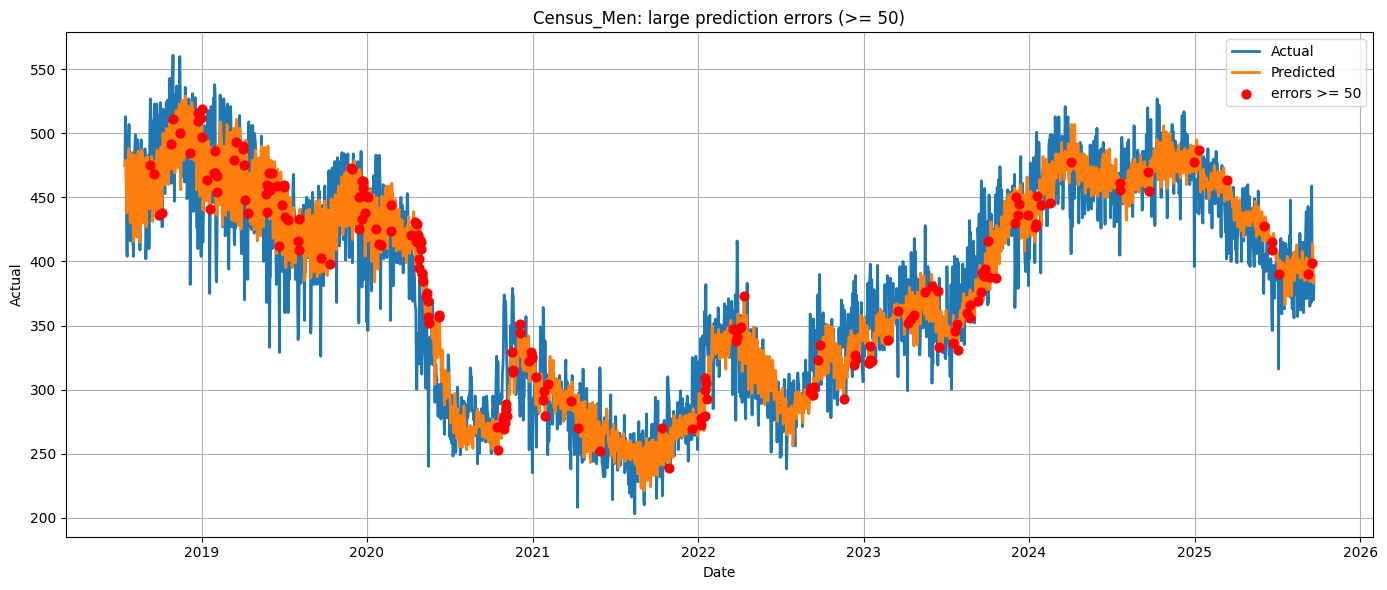

In [106]:
def plot_predictions_highlight_large_errors(
    df,
    date_col="Date",
    actual_col="Actual",
    pred_col="AR_trend_pred",
    highlight_threshold=50,
    title="Actual vs predicted with highlighted large errors",
    start_date=None,
    end_date=None,
):
    """
    Plots the full Actual and Predicted curves, but only displays a marker
    on the dates where |Actual - Prediction| >= highlight_threshold.
    """

    # Make a copy
    df_plot = df.copy()
    df_plot[date_col] = pd.to_datetime(df_plot[date_col])
    df_plot = df_plot.sort_values(date_col)

    # Optional date restriction
    if start_date is not None:
        df_plot = df_plot[df_plot[date_col] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df_plot = df_plot[df_plot[date_col] <= pd.to_datetime(end_date)]

    # Compute absolute error
    df_plot["abs_error"] = (df_plot[actual_col] - df_plot[pred_col]).abs()

    # Rows above threshold
    df_big = df_plot[df_plot["abs_error"] >= highlight_threshold]

    # The full x and y
    x = df_plot[date_col]
    y_actual = df_plot[actual_col]
    y_pred = df_plot[pred_col]

    plt.figure(figsize=(14, 6))

    # plot full actual and predicted series
    plt.plot(x, y_actual, label="Actual", linewidth=2)
    plt.plot(x, y_pred, label="Predicted", linewidth=2)

    # highlight only the large-error points
    if not df_big.empty:
        plt.scatter(
            df_big[date_col],
            df_big[pred_col],
            color="red",
            s=40,
            label=f"errors >= {highlight_threshold}",
            zorder=3,
        )

    plt.xlabel("Date")
    plt.ylabel(actual_col)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_big  # return the rows with large errors if you want to inspect them

big_errors_df = plot_predictions_highlight_large_errors(
    preds_best,
    highlight_threshold=50,
    title="Census_Men: large prediction errors (>= 50)"
)



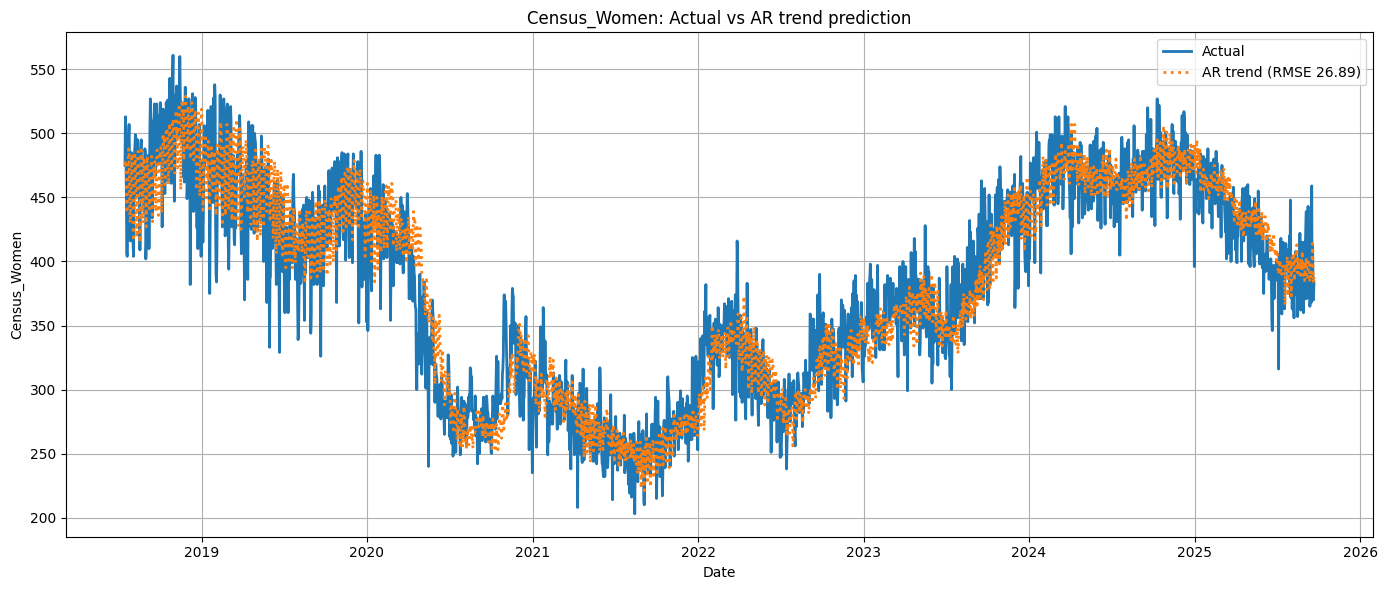

RMSE Naive      30.71
RMSE AR trend   26.89


In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

def plot_ar_trend_vs_naive(df, target_col="Census_Women"):
    """
    df columns expected:
      Date   (datetime or string convertible)
      Actual
      Naive
      AR_trend_pred
    """

    plot_df = df.copy().sort_values("Date")
    plot_df["Date"] = pd.to_datetime(plot_df["Date"])

    rmse_naive = root_mean_squared_error(plot_df["Actual"], plot_df["Naive"])
    rmse_ar = root_mean_squared_error(plot_df["Actual"], plot_df["AR_trend_pred"])

    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["Date"], plot_df["Actual"], label="Actual", linewidth=2)
    plt.plot(
        plot_df["Date"],
        plot_df["AR_trend_pred"],
        label=f"AR trend (RMSE {rmse_ar:.2f})",
        linestyle=":",
        linewidth=2,
    )

    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.title(f"{target_col}: Actual vs AR trend prediction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"RMSE Naive      {rmse_naive:.2f}")
    print(f"RMSE AR trend   {rmse_ar:.2f}")

plot_ar_trend_vs_naive(preds_best, target_col="Census_Women")


In [108]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

def evaluate_three_day_block_rmse(df):
    """
    df must have columns:
      Date, Actual, Naive, AR_trend_pred

    Returns:
      df_blocks   dataframe with three day block sums
      metrics     dict with RMSE for Naive and AR model on blocks
    """

    work = df.copy().sort_values("Date").reset_index(drop=True)
    work["Date"] = pd.to_datetime(work["Date"])

    # centered rolling window of size 3 gives d minus 1, d, d plus 1
    work["Actual_3sum"] = work["Actual"].rolling(window=3, center=True).sum()
    work["Naive_3sum"] = work["Naive"].rolling(window=3, center=True).sum()
    work["AR_3sum"] = work["AR_trend_pred"].rolling(window=3, center=True).sum()

    # first and last row have no full three day window
    block_df = work.dropna(subset=["Actual_3sum", "Naive_3sum", "AR_3sum"]).reset_index(drop=True)

    rmse_naive_3 = root_mean_squared_error(block_df["Actual_3sum"], block_df["Naive_3sum"])
    rmse_ar_3 = root_mean_squared_error(block_df["Actual_3sum"], block_df["AR_3sum"])

    metrics = {
        "rmse_naive_3day": rmse_naive_3,
        "rmse_ar_3day": rmse_ar_3,
    }

    return block_df[["Date", "Actual_3sum", "Naive_3sum", "AR_3sum"]], metrics


blocks_df, block_metrics = evaluate_three_day_block_rmse(preds_best)

print("RMSE on three day sums")
print(f"  Naive   {block_metrics['rmse_naive_3day']:.2f}")
print(f"  AR trend {block_metrics['rmse_ar_3day']:.2f}")

blocks_df.head()


RMSE on three day sums
  Naive   70.46
  AR trend 66.63


,Date,Actual_3sum,Naive_3sum,AR_3sum
0,2018-07-17,1480.0,1346.0,1429.0
1,2018-07-18,1460.0,1348.0,1413.0
2,2018-07-19,1353.0,1342.0,1372.0
3,2018-07-20,1265.0,1344.0,1339.0
4,2018-07-21,1256.0,1338.0,1344.0
